<a href="https://colab.research.google.com/github/Pratamartin/NodeBackend/blob/main/bbc_news_classifications_pesos_congelados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Alunos: Alexandre Gadelha e Martinho Prata Dos Santos

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import kagglehub


In [3]:
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/bbc-articles-dataset


In [4]:
df = pd.read_csv("/kaggle/input/bbc-articles-dataset/archive (2)/bbc-news-data.csv", sep='\t', encoding='utf-8')


In [5]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [6]:
df.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [7]:
df["category"].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [8]:
# Pré-processamento: concatenar title + content numa única coluna de texto

df['text'] = df['title'].str.strip() + ' ' + df['content'].str.strip()

In [9]:
# Codificar as labels de categoria como inteiros

le = LabelEncoder()
df['y'] = le.fit_transform(df['category'])

In [10]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['y'], test_size=0.2, random_state=42, stratify=df['y']
)


In [11]:
print(f"train: {len(X_train)}")
print(f"test: {len(y_test)}")

train: 1780
test: 445


In [12]:
# Carregar o modelo de embeddings (com pesos congelados)
embedder = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
# Gerar embeddings (batch-encode para acelerar)
X_train_emb = embedder.encode(X_train.tolist(), show_progress_bar=True, convert_to_numpy=True)
X_test_emb  = embedder.encode(X_test.tolist(),  show_progress_bar=True, convert_to_numpy=True)


Batches:   0%|          | 0/56 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [14]:
# Treinar o classificador
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train_emb, y_train)

LogisticRegression(max_iter=10000)

In [15]:
# Avaliar no conjunto de teste
y_pred = clf.predict(X_test_emb)

In [16]:
# Métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Acurácia: 0.9820224719101124

Relatório de Classificação:
               precision    recall  f1-score   support

     business       0.98      0.96      0.97       102
entertainment       1.00      1.00      1.00        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.95      0.99      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [21]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print("\nMatriz de Confusão:")
print(cm_df)



Matriz de Confusão:
               business  entertainment  politics  sport  tech
business             98              0         2      0     2
entertainment         0             77         0      0     0
politics              1              0        81      0     2
sport                 0              0         0    102     0
tech                  1              0         0      0    79


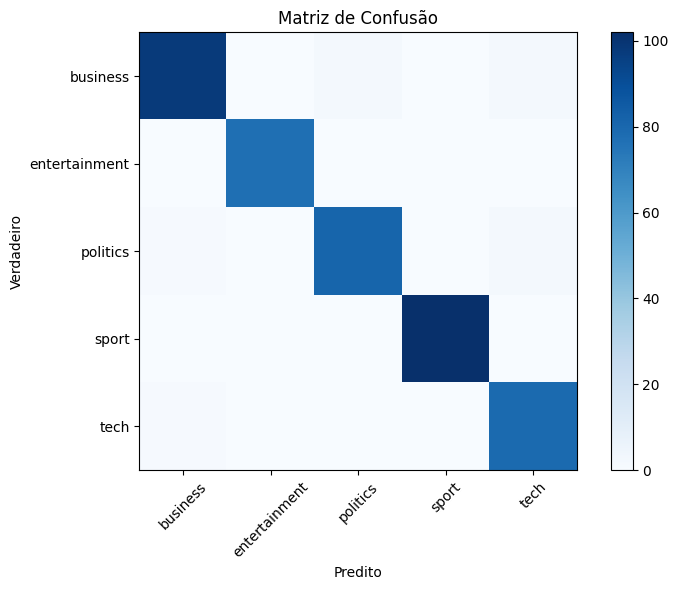

In [22]:
# Visualização da matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = range(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()